# marine controlled-source EM inversion -- _with automatic grid_

- use of `emg3d` + `SimPEG`

based on `simpeg-emg3d-inversion.ipynb`

This example uses a different computational mesh than the inversion mesh; but the same for all sources and all frequencies. The main point is that the computational mesh has a much larger extent than the inversion mesh.

Using the up-to-date (2022-03-11) branch:

- SimPEG: https://github.com/simpeg/simpeg/tree/emg3d-solver
- emg3d: `>=v1.5.0`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import SimPEG
import discretize
from pymatsolver import Pardiso
import SimPEG.electromagnetics.frequency_domain as FDEM

## Create a model

In [2]:
hx = np.ones(24)*200
hy = np.ones(12)*200
hz = np.ones(16)*200

In [3]:
mesh = discretize.TensorMesh([hx, hy, hz], x0=[-2400, -1200, -3000])

(-3000.0, 0.0)

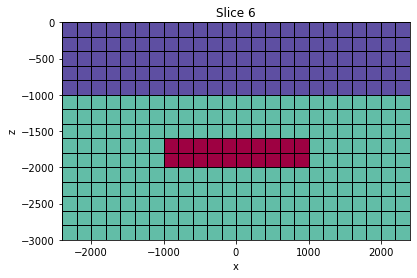

In [4]:
inds_air = mesh.cell_centers[:,2]>0.
inds_seafloor = mesh.cell_centers[:,2]<-1000.
inds_hydrocarbon = (
    np.logical_and(mesh.cell_centers[:,2]<-1600, mesh.cell_centers[:,2]>-2000) 
    & np.logical_and(mesh.cell_centers[:,0]>-1000, mesh.cell_centers[:,0]<1000)
    & np.logical_and(mesh.cell_centers[:,1]>-1000, mesh.cell_centers[:,1]<1000)
)

sigma = np.ones(mesh.n_cells) * 1./0.33
sigma[inds_air] = 1./1e8
sigma[inds_seafloor] = 1./1.
sigma[inds_hydrocarbon] = 1./100
fig, ax = plt.subplots(1,1, figsize=(8, 4))
mesh.plot_slice(
    1./sigma, grid=True, normal='Y', 
#     grid_opts={'color':'grey', 'linewidth':1},
    pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=0.33, vmax=100)}, 
    ax=ax,
)
ax.set_aspect(1)
ax.set_ylim(mesh.vectorNz.min(), 0)

In [5]:
inds_active = mesh.cell_centers[:,2]<-1000.

## Create a survey

In [6]:
# there is funcy behavior ... had to use this way ???
rec_x = np.arange(-2100, 2101, 44)
rec_y =  np.r_[0.0]
rec_z = np.array([-850])
xyz_rx = SimPEG.utils.ndgrid(rec_x, rec_y, rec_z)
src_x = np.arange(-2000, 2001, 500)
src_y = np.r_[0]
src_z = np.array([-1000])
xyz_src = SimPEG.utils.ndgrid(src_x, src_y, src_z)

(-5000.0, 5000.0)

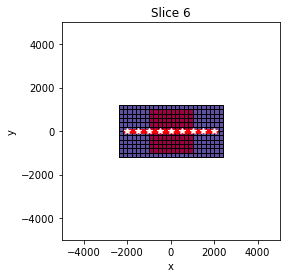

In [7]:
mesh.plot_slice(
    1./sigma, grid=True, normal='Z', 
    ind=6,
    pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=1, vmax=100)}, 
)
plt.plot(xyz_rx[:,0], xyz_rx[:,1], 'r.')
plt.plot(xyz_src[:,0], xyz_src[:,1], 'w*')
plt.gca().set_aspect(1)
plt.xlim(-5000, 5000)
plt.ylim(-5000, 5000)

In [8]:
frequency = 1
rx_list = [
    FDEM.receivers.PointElectricField(
        orientation='x', component="complex", locations=xyz_rx),
]

# vector = np.real(sfield.field/-sfield.smu0)
src_list = []
for ii in range(xyz_src.shape[0]):
    src = FDEM.sources.ElectricDipole(rx_list, location=xyz_src[ii,:], frequency=frequency, azimuth=0, elevation=0)
    src_list.append(src)
survey = FDEM.Survey(src_list)

## Create simulation

In [9]:
active_map = SimPEG.maps.InjectActiveCells(mesh, inds_active, sigma[~inds_active])
nP = int(inds_active.sum())
conductivity_map = active_map * SimPEG.maps.ExpMap(nP=nP)
# conductivity_map = SimPEG.maps.IdentityMap(mesh)

In [10]:
# Define the Simulation
simulation = FDEM.Simulation3DEMG3D(
        mesh,
        survey=survey,
        sigmaMap=conductivity_map,
        solver=Pardiso,
        verbose=False,
        simulation_opts={
            'max_workers': 10, 
            'gridding': 'single',
            'model': emg3d.Model(mesh, sigma, mapping='Conductivity'),
            'gridding_opts': {
                'seasurface': 0.0,
                'center': (0, 0, -1000),
                'vector': 'xyz',
                'domain': ([-2000, 2000], [-1500, 1500], [-2500, 0]),
                'min_width_limits': (200, 400, 100),
                'max_buffer': 50_000,
                'lambda_from_center': True,
                'center_on_edge': False,
            },
        },
)

m_true =  np.log(sigma[inds_active])
# m_true =  np.ones(mesh.nC)
m0 =  np.ones(inds_active.sum()) * np.log(1.)

m2 = simulation.emg3d_sim.get_model('TxED-1', 'f-1')
m2.grid

TensorMesh: 61,440 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     48    -50,019.12     50,019.12    200.00 12,475.57    1.34
   y     40    -51,022.23     51,022.23    200.00 15,165.89    1.43
   z     32     -5,276.91     50,104.92    200.00 13,148.46    1.35

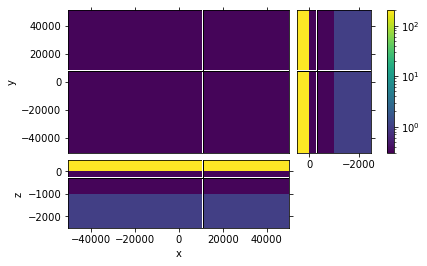

In [11]:
m2.grid.plot_3d_slicer(1/m2.property_x, xslice=12000, yslice=7000,
                       zlim=[-2500, 500],
                       pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=200)})

In [12]:
f = simulation.fields(m_true)
d_true = simulation.dpred(m_true, f=f)

In [13]:
d_0 = simulation.dpred(m0)

In [14]:
relative_error = 0.01
noise_floor = 1e-14
standard_deviation = np.sqrt(abs(relative_error*d_true)**2 + (noise_floor)**2)

In [15]:
residual = (d_true - d_0)/standard_deviation

In [16]:
np.vdot(residual, residual).real

412050.71990387136

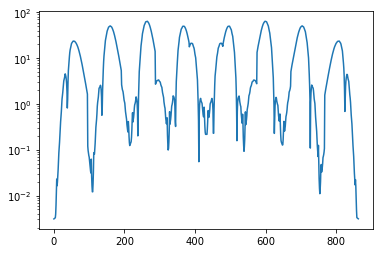

In [17]:
plt.semilogy(abs(residual), label='dobs')
# plt.semilogy(standard_deviation,label='std')

(array([ 31.,  65., 115., 136., 109.,  91.,  78.,  81.,  99.,  59.]),
 array([-13.84936453, -13.27002032, -12.69067611, -12.1113319 ,
        -11.53198769, -10.95264348, -10.37329927,  -9.79395506,
         -9.21461085,  -8.63526664,  -8.05592243]),
 <BarContainer object of 10 artists>)

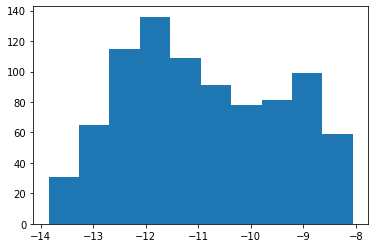

In [18]:
plt.hist(np.log10(abs(d_true)))

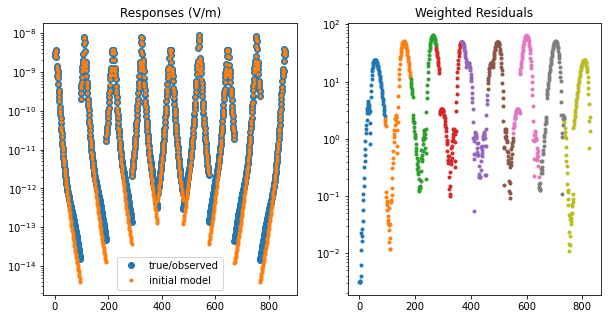

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('Responses (V/m)')
ax1.semilogy(abs(d_true), 'o', label='true/observed')
ax1.semilogy(abs(d_0), '.', label='initial model')
ax1.legend()

ax2.set_title('Weighted Residuals')
nsrc = xyz_src.shape[0]
nrec = len(rec_x)-4
x = np.arange(len(residual))
for s in range(nsrc):
    ax2.semilogy(x[s*nrec:(s+1)*nrec], abs(residual[s*nrec:(s+1)*nrec]), '.')

plt.show()

In [20]:
em_data = SimPEG.data.ComplexData(survey, dobs=d_true, standard_deviation=standard_deviation)
dmis = SimPEG.data_misfit.L2DataMisfit(data=em_data, simulation=simulation)

In [21]:
def test_misfit():
    passed = discretize.tests.check_derivative(
        fctn=lambda m: (simulation.dpred(m), lambda mx: simulation.Jvec(m0, mx, f=f)),
        x0=m0,
        plotIt=False,
        num=3,
    )

def test_adjoint():
    f = simulation.fields(m=m0)   
    _ = discretize.tests.assert_isadjoint(
        forward=lambda u: simulation.Jvec(m0, u, f=f).real,
        adjoint=lambda v: simulation.Jtvec(m0, v, f=f),
        shape_u=inds_active.sum(),
        shape_v=simulation.survey.nD,
        assert_error=False,
    )
    
def test_dataObj():
    discretize.tests.check_derivative(
        fctn=lambda m: [dmis(m), dmis.deriv(m)],
        x0=m0,
        plotIt=False,
        num=2,
    )

In [22]:
test_dataObj()

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.078e+04     5.360e+03      nan
 1   1.00e-02    5.943e+02     5.192e+01      2.014
========================= PASS! =========================
The test be workin!



In [23]:
test_misfit()

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    3.760e-10     5.291e-11      nan
 1   1.00e-02    3.661e-11     5.384e-13      1.992
 2   1.00e-03    3.653e-12     5.394e-15      1.999
========================= PASS! =========================
You are awesome.



In [24]:
test_adjoint()

Adjoint test PASSED ::  7.361e-17 < 4.325e-15  :: |rhs-lhs| < atol + rtol|lhs|


In [25]:
%%time

# Define the regularization (model objective function)
reg = SimPEG.regularization.Tikhonov(
    mesh,
    indActive=inds_active,
    mref=m0,
    alpha_s=1e-8,
    alpha_x=1,
    alpha_y=10,
    alpha_z=1
)

opt = SimPEG.optimization.InexactGaussNewton(
    maxIter=20,
    #maxIterLS=20,
    maxIterCG=20,
    tolCG=1e-3
)

inv_prob = SimPEG.inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = SimPEG.directives.BetaEstimate_ByEig(beta0_ratio=1)
save = SimPEG.directives.SaveOutputDictEveryIteration()

beta_schedule = SimPEG.directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target_misfit = SimPEG.directives.TargetMisfit(chifact=1)

directives_list = [
    starting_beta,
    beta_schedule,
    target_misfit,
    save
]
em_inversion = SimPEG.inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = em_inversion.run(m0)


            SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
            ***Done using same Solver and solverOpts as the problem***


/home/dwm/miniconda3/envs/inv-dev/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.16e+00  2.06e+05  0.00e+00  2.06e+05    6.52e+04      0              


/home/dwm/miniconda3/envs/inv-dev/lib/python3.9/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   1  2.58e+00  6.53e+04  2.19e+03  7.09e+04    1.55e+04      0              
   2  1.29e+00  3.45e+04  6.08e+03  4.23e+04    6.87e+03      0              
   3  6.45e-01  2.16e+04  1.06e+04  2.85e+04    5.21e+03      0   Skip BFGS  
   4  3.22e-01  1.49e+04  1.62e+04  2.01e+04    4.79e+03      0   Skip BFGS  
   5  1.61e-01  9.60e+03  2.49e+04  1.36e+04    3.60e+03      0   Skip BFGS  
   6  8.06e-02  6.79e+03  3.45e+04  9.57e+03    3.31e+03      0   Skip BFGS  
   7  4.03e-02  4.83e+03  4.69e+04  6.72e+03    1.72e+03      0   Skip BFGS  
   8  2.01e-02  3.62e+03  5.74e+04  4.77e+03    1.25e+03      0              
   9  1.01e-02  2.98e+03  6.35e+04  3.61e+03    1.27e+03      0              
  10  5.04e-03  2.10e+03  1.01e+05  2.60e+03    3.15e+03      0              
  11  2.52e-03  1.54e+03  1.01e+05  1.80e+03    7.64e+02      0              
  12  1.26e-03  1.24e+03  1.20e+05  1.39e+03    1.35e+03      0              
  13  6.30e-04  9.80e+02  1.33e+05  1.06e+03    7.38e+02      0 

In [26]:
target_misfit.target

432.0

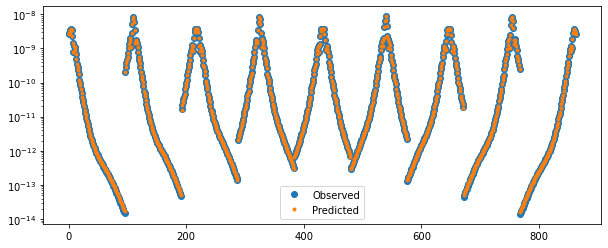

In [27]:
plt.figure(figsize=(10, 4))
iteration = len(save.outDict.keys())
plt.semilogy(abs(em_data.dobs), 'o', label='Observed')
plt.semilogy(abs(save.outDict[iteration]['dpred']), '.', label='Predicted')
plt.legend()

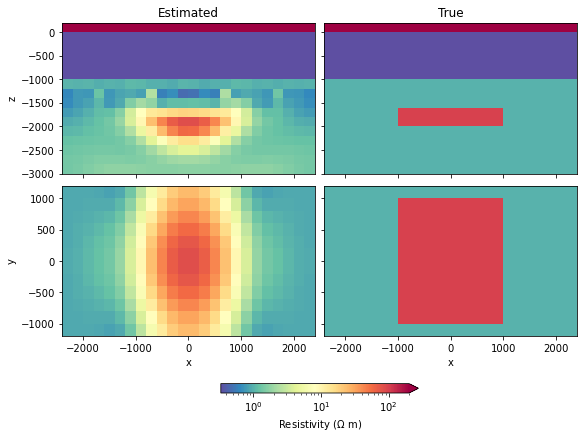

In [61]:
opts = {'grid': False}
popts = {'cmap':'Spectral_r', 'norm':LogNorm(vmin=0.33, vmax=200)}

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey='row', constrained_layout=True)

sigm_est = conductivity_map * save.outDict[iteration]['m']
sigmas = [sigm_est, sigma]
titles = ["Estimated", "True"]
for ii, ax in enumerate(axs[0, :]):
    out = mesh.plot_slice(
        1./sigmas[ii], grid=False, normal='Y',
        pcolor_opts=popts, ax=ax)
    ax.set_title(titles[ii])
    ax.set_xlabel('')

for ii, ax in enumerate(axs[1, :]):
    out = mesh.plot_slice(
        1./sigmas[ii], grid=False, normal='Z', ind=5,
        pcolor_opts=popts, ax=ax)
    ax.set_title('')
    
for ax in axs[:, 1]:
    ax.set_ylabel('')
       
cb = plt.colorbar(out[0], ax=axs, fraction=0.03, extend='max', orientation='horizontal')
cb.set_label("Resistivity ($\Omega$ m)")

In [29]:
SimPEG.Report(emg3d)

--------------------------------------------------------------------------------
  Date: Wed Mar 30 22:13:03 2022 CEST

                OS : Linux
            CPU(s) : 32
           Machine : x86_64
      Architecture : 64bit
               RAM : 125.7 GiB
       Environment : Jupyter

  Python 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03)  [GCC
  9.4.0]

             emg3d : 1.4.1.dev11+g4c90a09
            SimPEG : 0.14.3
        discretize : 0.7.3
       pymatsolver : 0.2.0
        vectormath : 0.2.2
        properties : 0.6.1
             numpy : 1.20.3
             scipy : 1.7.1
            cython : 0.29.24
           IPython : 7.28.0
        matplotlib : 3.4.3
        ipywidgets : 7.6.5

  Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------